In [1]:
"""
Expects a csv file with image id, maxlat, maxlon, minlat, minlon of each satellite image
Expects json files as a folder with the polygons parsed from the shapefile
Expects images for overlaying masks on images

"""

import json
import numpy as np
import pandas as pd
import sys
import os
import cv2
import imageio
import csv
import copy
import matplotlib.pyplot as plt
from PIL import Image
from collections import defaultdict 
from shapely.geometry import box, Polygon

# Make all experiments have 10,000 labeled fields exactly

## Helper functions

In [2]:
def create_empty_overlays(grid, orig_images_dir, prefix='', suffix='', n=100):
    """
    Initiate empty masks and original images into the output folder based on the
    
    Args:
        grid (list): information from csv, so the empty masks to be overwritten later
    """
    for index in range(len(grid.keys())):
        image_id = str(grid[index]['image_id']).zfill(5)
        if image_id >= str(n).zfill(5):
            break
            
        im_name = os.path.join(orig_images_dir, str(prefix) + str(image_id) + str(suffix) + '.tif')
        orig_image = cv2.imread(im_name)
        overlay_path = os.path.join(base_dir, overlay_folder, str(image_id) + '.jpeg')
        cv2.imwrite(overlay_path, orig_image)

def create_dict_parcels(shp_dict):
    """
    Put the found fields from the parsed json into dict of image ids
    Args:
        shp_dict (dict): json dict containing the polygon fields

    Returns:
        dict: contains image id to polygons
    """
    dict_parcels = defaultdict(list) 
    for sh_index, sh in enumerate(shp_dict['features']):
        id_list = sh['properties']['image_id']
        for image_id in id_list:
            dict_parcels[image_id].append(sh)
    return dict_parcels

def scale_coords(shape_size, geom, grid, index):
    """
    scales the polygons lat/lon to pixel 
    Args:
        shape_size (tuple): size of the image to be scaled to
        geom (polygon): field polygon
        grid (list): values of min/max lat/lon for each image id
        index (int): Index of each image id in grid

    Returns:
        list: scaled coordinates
    """
    w, h = shape_size
    min_lat, min_lon, max_lat, max_lon = grid[index]['min_lat'], grid[index]['min_lon'], \
        grid[index]['max_lat'], grid[index]['max_lon']
    x = geom[:,0]
    y = geom[:,1]
    scale_lon = w / (max_lon - min_lon)
    scale_lat = h / (max_lat - min_lat)
    scaled_x = (x - min_lon) * scale_lon # lon-> x, lat->y
    scaled_y = h - ((y - min_lat) * scale_lat)
    if any(val > w for val in scaled_x) or any(val > h for val in scaled_y) \
        or any(val < 0 for val in scaled_x) or any (val < 0 for val in scaled_y):
        return np.concatenate([scaled_x[:,None], scaled_y[:,None]],axis=1)
    return np.concatenate([scaled_x[:,None], scaled_y[:,None]],axis=1)

In [3]:
def get_grid(df):
    """
    Read the CSV file containing minmax lat/lon and stores it to a 2D list

    Args:
        df: pandas dataframe of bounding boxes

    Returns:
        list: contains the imag_id and lat/long information
    """
    grid = dict()
    keys = ['max_lat', 'max_lon', 'min_lat', 'min_lon']

    for index, row in df.iterrows():
        if index not in grid:
            grid[index] = dict()
        grid[index]['image_id'] = row['image_id']
        grid[index]['max_lat'] = float(row['max_lat'])
        grid[index]['max_lon'] = float(row['max_lon'])
        grid[index]['min_lat'] = float(row['min_lat'])
        grid[index]['min_lon'] = float(row['min_lon'])
        
    return grid

In [253]:
# ======================== USER SETUP ======================== #b
# Directories to read the necessary files from
year_month = '_2019_04'
thickness = 6
downsample = 3
total_to_sample = 13500
n_to_sample = 100
n_images = 125

base_dir = '../data/planet/france/sherrie10k/'
label_folder = 'extent_labels/1250px_{}field/original_thickness{}'.format(n_to_sample, thickness)
csv_file = os.path.join(base_dir, 'bbox10k_1250px.csv')
orig_images_dir = os.path.join(base_dir, 'monthly_mosaics_renamed_clipped_merged', '1250px', 'original', '2019_04')
# ============================================================ #
# create output directory if not exist
if os.path.exists(os.path.join(base_dir, label_folder)) == False:
    os.makedirs(os.path.join(base_dir, label_folder))
    
df = pd.read_csv(csv_file)
df['image_id'] = df['image_id'].astype(str).str.zfill(5)
grid = get_grid(df)

In [255]:
json_files = sorted([x for x in os.listdir('../data/planet/france/sherrie10k/json_polys/') if 'bbox10k_1250px' in x])
codes_to_keep = list(range(1,10)) + [11,14,15,16,17,18,19,21,24,25,26,28]
sampled_dict = {str(x).zfill(5): [] for x in range(n_images)}
n_fields_sampled = 0
iteration = 0

for k, json_name in enumerate(json_files):
    if k > 0:
        break
    json_file = os.path.join('../data/planet/france/sherrie10k/json_polys', json_name)

    # read multiple json files
    print('Read json', json_file)

    # open the saved json file for the found parcels in the images 
    with open(json_file) as f:
        shp_dict = json.load(f)

    # create dictionary of polygons in each image for fast indexing
    parcels_dict = create_dict_parcels(shp_dict)

    while n_fields_sampled < total_to_sample:
        print("iteration:", iteration)
        
        # find the polygons of each image and plot them
        for index in range(n_images):

            image_id = grid[index]['image_id']
            polys = []
            if image_id in parcels_dict:
                img = imageio.imread(os.path.join(orig_images_dir, image_id + year_month + '.tif'))
                shape_size = (img.shape[0], img.shape[1])
                extent_path = os.path.join(base_dir, label_folder, str(image_id) + '.png')
                extent_label = np.zeros(shape_size)
                if os.path.exists(extent_path) and iteration > 0:
                    extent_label = imageio.imread(extent_path)
                extent_label_original = copy.deepcopy(extent_label)

                # find set of parcels that intersect 256x256 image
                row = df[df['image_id'] == image_id]
                min_lon, min_lat, max_lon, max_lat = row['min_lon'].values[0], \
                    row['min_lat'].values[0], row['max_lon'].values[0], row['max_lat'].values[0]
                # TODO adjust lat/lon by image size vs 256x256
                image_bbox = box(min_lon, min_lat, max_lon, max_lat)
                image_polys = []
                
                for sh in parcels_dict[image_id]:
                    if int(sh['properties']['CODE_GROUP']) in codes_to_keep:
                        try:
                            geom = Polygon(sh['geometry']['coordinates'][0])
                            if geom.intersects(image_bbox):
                                image_polys.append(sh)
                        except:
                            print("Exception in image", image_id)

                # label one field in image at random
                if len(image_polys) == 0:
                    # print("no polygons of field crops", image_id)
                    continue
                else:
                    if len(image_polys) > iteration:
                        sh = image_polys[iteration]
                        temp_extent_label = np.zeros(shape_size)
                        for coord_idx in range(len(sh['geometry']['coordinates'])):
                            geom = np.array(sh['geometry']['coordinates'][coord_idx])
                            try:
                                geom_fixed = scale_coords(shape_size, geom, grid, index)
                            except:
                                print("Exception in image {}".format(image_id))
                                print(geom)
                            pts = geom_fixed.astype(int)

                            # add polygon to temp label
                            cv2.fillPoly(temp_extent_label, [pts], color=1)
                            cv2.polylines(temp_extent_label, [pts], True, color=0, thickness=thickness)

                            # add polygon to real label
                            cv2.fillPoly(extent_label, [pts], color=iteration+1)
                            cv2.polylines(extent_label, [pts], True, color=0, thickness=thickness)
                            polys.append(pts)
                            
#                         test_image = (temp_extent_label[:256*downsample, :256*downsample] - \
#                             (extent_label_original[:256*downsample, :256*downsample] > 0)) > 0
                        
#                         if image_id == '00018' and iteration == 5:
#                             print("image id:", image_id)
#                             fig, ax = plt.subplots(1, 3, figsize=(12, 4))
#                             ax[0].imshow(extent_label_original[:256*downsample, :256*downsample])
#                             ax[1].imshow(temp_extent_label[:256*downsample, :256*downsample])
#                             ax[2].imshow(test_image)
#                             plt.show()
#                             print("np.sum(test_image)", np.sum(test_image))

                        # Save the extent label
                        cv2.imwrite(extent_path, extent_label)
        
                        # polygon is in top 256x256 of image
                        if np.sum(temp_extent_label[:256*downsample, :256*downsample]) > 0: # np.sum(test_image) > 0:
                            sampled_dict[image_id].append(iteration+1)
                            n_fields_sampled += 1

                        # check if done sampling
                        if n_fields_sampled >= total_to_sample:
                            break
        
        # completed one loop through images
        iteration += 1
        print("n_fields_sampled:", n_fields_sampled)

Read json ../data/planet/france/sherrie10k/json_polys/bbox10k_1250px_0_285241.json
iteration: 0
n_fields_sampled: 54
iteration: 1
n_fields_sampled: 111
iteration: 2
n_fields_sampled: 164
iteration: 3
n_fields_sampled: 216
iteration: 4
n_fields_sampled: 261
iteration: 5
n_fields_sampled: 301
iteration: 6
n_fields_sampled: 360
iteration: 7
n_fields_sampled: 415
iteration: 8
n_fields_sampled: 471
iteration: 9
n_fields_sampled: 516
iteration: 10
n_fields_sampled: 570
iteration: 11
n_fields_sampled: 619
iteration: 12
n_fields_sampled: 661
iteration: 13
n_fields_sampled: 701
iteration: 14
n_fields_sampled: 750
iteration: 15
n_fields_sampled: 797
iteration: 16
n_fields_sampled: 844
iteration: 17
n_fields_sampled: 891
iteration: 18
n_fields_sampled: 938
iteration: 19
n_fields_sampled: 979
iteration: 20
n_fields_sampled: 1025
iteration: 21
n_fields_sampled: 1077
iteration: 22
n_fields_sampled: 1130
iteration: 23
n_fields_sampled: 1186
iteration: 24
n_fields_sampled: 1240
iteration: 25
n_fields_

n_fields_sampled: 8837
iteration: 218
n_fields_sampled: 8868
iteration: 219
n_fields_sampled: 8901
iteration: 220
n_fields_sampled: 8936
iteration: 221
n_fields_sampled: 8961
iteration: 222
n_fields_sampled: 8996
iteration: 223
n_fields_sampled: 9027
iteration: 224
n_fields_sampled: 9062
iteration: 225
n_fields_sampled: 9091
iteration: 226
n_fields_sampled: 9121
iteration: 227
n_fields_sampled: 9150
iteration: 228
n_fields_sampled: 9177
iteration: 229
n_fields_sampled: 9204
iteration: 230
n_fields_sampled: 9236
iteration: 231
n_fields_sampled: 9278
iteration: 232
n_fields_sampled: 9311
iteration: 233
n_fields_sampled: 9340
iteration: 234
n_fields_sampled: 9369
iteration: 235
n_fields_sampled: 9404
iteration: 236
n_fields_sampled: 9437
iteration: 237
n_fields_sampled: 9466
iteration: 238
n_fields_sampled: 9493
iteration: 239
n_fields_sampled: 9524
iteration: 240
n_fields_sampled: 9557
iteration: 241
n_fields_sampled: 9588
iteration: 242
n_fields_sampled: 9620
iteration: 243
n_fields_sam

n_fields_sampled: 12482
iteration: 430
n_fields_sampled: 12493
iteration: 431
n_fields_sampled: 12503
iteration: 432
n_fields_sampled: 12512
iteration: 433
n_fields_sampled: 12520
iteration: 434
n_fields_sampled: 12528
iteration: 435
n_fields_sampled: 12532
iteration: 436
n_fields_sampled: 12538
iteration: 437
n_fields_sampled: 12546
iteration: 438
n_fields_sampled: 12555
iteration: 439
n_fields_sampled: 12563
iteration: 440
n_fields_sampled: 12573
iteration: 441
n_fields_sampled: 12583
iteration: 442
n_fields_sampled: 12593
iteration: 443
n_fields_sampled: 12599
iteration: 444
n_fields_sampled: 12609
iteration: 445
n_fields_sampled: 12614
iteration: 446
n_fields_sampled: 12620
iteration: 447
n_fields_sampled: 12624
iteration: 448
n_fields_sampled: 12630
iteration: 449
n_fields_sampled: 12637
iteration: 450
n_fields_sampled: 12645
iteration: 451
n_fields_sampled: 12651
iteration: 452
n_fields_sampled: 12656
iteration: 453
n_fields_sampled: 12664
iteration: 454
n_fields_sampled: 12673
i

n_fields_sampled: 13217
iteration: 641
n_fields_sampled: 13218
iteration: 642
n_fields_sampled: 13218
iteration: 643
n_fields_sampled: 13220
iteration: 644
n_fields_sampled: 13222
iteration: 645
n_fields_sampled: 13225
iteration: 646
n_fields_sampled: 13227
iteration: 647
n_fields_sampled: 13227
iteration: 648
n_fields_sampled: 13230
iteration: 649
n_fields_sampled: 13233
iteration: 650
n_fields_sampled: 13236
iteration: 651
n_fields_sampled: 13239
iteration: 652
n_fields_sampled: 13242
iteration: 653
n_fields_sampled: 13244
iteration: 654
n_fields_sampled: 13247
iteration: 655
n_fields_sampled: 13249
iteration: 656
n_fields_sampled: 13250
iteration: 657
n_fields_sampled: 13252
iteration: 658
n_fields_sampled: 13254
iteration: 659
n_fields_sampled: 13256
iteration: 660
n_fields_sampled: 13258
iteration: 661
n_fields_sampled: 13259
iteration: 662
n_fields_sampled: 13261
iteration: 663
n_fields_sampled: 13262
iteration: 664
n_fields_sampled: 13264
iteration: 665
n_fields_sampled: 13265
i

KeyboardInterrupt: 

In [207]:
n_fields_available = 0
for i in range(n_images):
    image_id = str(i).zfill(5)
    n_fields_available += len(parcels_dict[image_id])

In [259]:
np.mean(list(n_fields_actual.values()))

79.664

In [256]:
n_fields = 0
n_fields_actual = {}
for i in range(n_images):
    image_id = str(i).zfill(5)
    if os.path.exists('../data/planet/france/sherrie10k/extent_labels/1250px_100field/original_thickness6/{}.png'.format(image_id)):
        im = imageio.imread('../data/planet/france/sherrie10k/extent_labels/1250px_100field/original_thickness6/{}.png'.format(image_id))
    #     print(np.unique(im[:256*3, :256*3]))
        if 0 in np.unique(im[:256*3,:256*3]):
            n_fields += len(np.unique(im[:256*3,:256*3])) - 1
            n_fields_actual[image_id] = len(np.unique(im[:256*3,:256*3])) - 1
            if list(np.unique(im[:256*3,:256*3])[1:]) != list(sampled_dict[image_id]):
                print(image_id, "does not match")
                print("unique:", np.unique(im[:256*3,:256*3]))
                print("sampled:", sampled_dict[image_id])
        else:
            n_fields += len(np.unique(im[:256*3,:256*3]))
            n_fields_actual[image_id] = len(np.unique(im[:256*3,:256*3]))

00000 does not match
unique: [  0   3   4   5   6   7   8  17  18  23  24  26  27  28  30  32  34  35
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  63  65  66  67  68  70  71  72  73  74  75  76  77  78  79  81
  82  85  86  88  89  90  91  93  95  96 102 103 105 106 107 108 109 110
 111 112 113 115 116 117 118 119 120 121 122 123 124 148 149 150 151 175
 206 215 223 231 232 236 237 240 242 243 246 247 248 249 250 251 252 253
 254 255]
sampled: [3, 4, 5, 6, 7, 8, 17, 18, 23, 24, 26, 27, 28, 30, 32, 34, 35, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 82, 85, 86, 88, 89, 90, 91, 93, 95, 96, 102, 103, 105, 106, 107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 148, 149, 150, 151, 175, 206, 215, 223, 231, 232, 236, 237, 240, 242, 243, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 257, 258, 259, 260, 261, 262, 264

00009 does not match
unique: [  0   5   6   8  11  13  14  15  18  19  20  21  26  40  45  46  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  72  74  75  77  78
 107 108 109 113 117 118 120 124 125 126 127 128 129 131 132 147 150 151
 152 153 154 155 156 157 158 159 160 161 163 164 166 167 168 169 170 172
 174 175 176 177 179 180 181 182 183 184 185 187 190 191 192 193 194 196
 197 198 199 201 202 203 205 206 207 208 214 215 220 221 222 223 224 225
 226 227 230 233 234 235 236 237 238 240 241 247 254 255]
sampled: [5, 6, 8, 11, 13, 14, 15, 18, 19, 20, 21, 26, 40, 45, 46, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 72, 74, 75, 77, 78, 107, 108, 109, 113, 117, 118, 120, 124, 125, 126, 127, 128, 129, 131, 132, 147, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 166, 167, 168, 169, 170, 172, 174, 175, 176, 177, 179, 180, 181, 182, 183, 184, 185, 187, 190, 191, 192, 193, 194, 196, 197, 198, 199, 201, 202, 203, 205, 206, 207, 208, 214, 215

00026 does not match
unique: [  0   5   8  24  28  29  30  31  37  41  46  51  52  53  54  55  56  66
  68  75  77  84  92  94  95  99 100 102 103 104 106 107 108 109 110 116
 119 120 122 125 126 127 131 133 134 135 136 138 139 140 141 142 146 158
 159 171 182 183 184 185 186 187 188 189 190 191 193 194 195 196 198 204
 205 208 211 214 215 216 217 220 221 223 224 225 230 231 234 236 240 244
 249 254 255]
sampled: [5, 8, 24, 28, 29, 30, 31, 37, 41, 46, 51, 52, 53, 54, 55, 56, 66, 68, 75, 77, 84, 92, 94, 95, 99, 100, 102, 103, 104, 106, 107, 108, 109, 110, 116, 119, 120, 122, 125, 126, 127, 131, 133, 134, 135, 136, 138, 139, 140, 141, 142, 146, 158, 159, 171, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 198, 204, 205, 208, 211, 214, 215, 216, 217, 220, 221, 223, 224, 225, 230, 231, 234, 236, 240, 244, 249, 254, 265, 267, 269, 270, 272, 274, 276, 280, 281, 282, 283, 285, 286, 290, 295, 296, 308, 310, 313, 322, 329, 330, 333, 335, 336, 337, 338, 339, 340, 341, 342,

00044 does not match
unique: [  0   1   3   4   5   7   8   9  10  11  12  14  15  16  17  19  23  24
  25  26  28  31  32  33  36  37  41  42  43  44  45  46  50  51  52  53
  54  55  56  57  60  61  80  82  85  87  88  89  90  93  94  96 108 109
 110 111 112 134 140 143 144 145 146 147 148 150 151 152 153 154 155 156
 159 160 163 164 165 166 167 168 169 170 171 172 179 187 197 198 199 201
 202 203 204 208 209 210 211 218 220 221 223 224 231 232 233 238 239]
sampled: [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 19, 23, 24, 25, 26, 28, 31, 32, 33, 36, 37, 41, 42, 43, 44, 45, 46, 50, 51, 52, 53, 54, 55, 56, 57, 60, 61, 80, 82, 85, 87, 88, 89, 90, 93, 94, 96, 108, 109, 110, 111, 112, 134, 140, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 159, 160, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 179, 187, 197, 198, 199, 201, 202, 203, 204, 208, 209, 210, 211, 218, 220, 221, 223, 224, 231, 232, 233, 238, 239]
00046 does not match
unique: [ 0  3  4  5  7  9 10 

00069 does not match
unique: [  0   2   3   4   6   7   8   9  10  12  16  19  20  61  62  63  64  65
  66  67  71  72  73  76  78  79  81  83  87  89  91  92  93  95  96  97
  98  99 100 101 102 103 104 105 108 109 110 111 112 113 115 117 119 120
 136 137 138 139 140 141 142 143 148 149 150 157 158 160 161 162 163 164
 165 167 168 169 170 172 180 181 182 183 184]
sampled: [2, 3, 4, 6, 7, 8, 9, 10, 12, 16, 19, 20, 61, 62, 63, 64, 65, 66, 67, 71, 72, 73, 76, 78, 79, 81, 83, 87, 89, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 108, 109, 110, 111, 112, 113, 115, 117, 119, 120, 136, 137, 138, 139, 140, 141, 142, 143, 148, 149, 150, 157, 158, 160, 161, 162, 163, 164, 165, 167, 168, 169, 170, 172, 180, 181, 182, 183, 184]
00070 does not match
unique: [  0   1   2   3   7   9  10  12  15  16  17  18  19  21  22  23  29  30
  33  34  36  37  38  39  40  41  42  45  46  47  58  59  60  61  62  63
  64  65  66  67  70  71  72  74  75  78  86  87  88  89  91  92  93  94
  95 

00079 does not match
unique: [  0   1   7   8  10  11  16  17  19  23  32  34  35  36  44  45  46  47
  57  58  59  60  61  62  65  68  70  72  73  74  78  79  80  81  82  83
  84  85  86  90  93  97 110 114 119 125 126 129 131 132 133 134 136 145
 146 147 150 154 160 166 175 176 177 196 197 198 208 211 212 213 214 236
 241 242 249 250 252 255]
sampled: [1, 7, 8, 10, 11, 16, 17, 19, 23, 32, 34, 35, 36, 44, 45, 46, 47, 57, 58, 59, 60, 61, 62, 65, 68, 70, 72, 73, 74, 78, 79, 80, 81, 82, 83, 84, 85, 86, 90, 93, 97, 110, 114, 119, 125, 126, 129, 131, 132, 133, 134, 136, 145, 146, 147, 150, 154, 160, 166, 175, 176, 177, 196, 197, 198, 208, 211, 212, 213, 214, 236, 241, 242, 249, 250, 252, 255, 263, 265, 266, 267, 268, 269, 278, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 308, 309, 310, 311, 319, 320]
00080 does not match
unique: [  0   7  10  16  17  19  23  24  25  26  28  29  30  32  33  34  36  38
  39  41  55  57  58  59  60  62  64  65  67  68  69  70  71  72  73  75
  76  77  78

00094 does not match
unique: [  0   2   8   9  10  11  17  20  21  22  23  24  25  31  32  33  36  37
  43  48  49  52  53  55  56  57  58  59  61  62  64  65  67  68  69  70
  71  72  73  74  79  80  81  82  83  84  86  91  92  94  95  96  97  99
 100 101 102 103 105 124 128 129 130 132 139 140 143 147 158 165 166 167
 168 169 170 176 177 178 179 180 181 185 186 187 195 198 232 236 237 238
 239 240 241 245 248 249 250 252 254 255]
sampled: [2, 8, 9, 10, 11, 17, 20, 21, 22, 23, 24, 25, 31, 32, 33, 36, 37, 43, 48, 49, 52, 53, 55, 56, 57, 58, 59, 61, 62, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 79, 80, 81, 82, 83, 84, 86, 88, 91, 92, 94, 95, 96, 97, 99, 100, 101, 102, 103, 105, 124, 128, 129, 130, 132, 139, 140, 143, 147, 158, 165, 166, 167, 168, 169, 170, 176, 177, 178, 179, 180, 181, 185, 186, 187, 195, 198, 232, 236, 237, 238, 239, 240, 241, 245, 248, 249, 250, 252, 254, 255, 259, 260, 261, 263, 264, 266, 267, 270, 278, 279, 280, 281, 295, 299, 300, 301, 302, 303, 304, 305, 314, 315, 3

00106 does not match
unique: [  0   4   8   9  10  11  12  25  30  33  38  41  45  46  47  48  49  50
  51  52  53  54  63  65  70  76  78  82  87  89  91  92  94  95  96  97
  98  99 102 103 104 115 116 121 124 125 127 132 134 135 136 137 138 139
 140 141 142 143 146 147 148 149 150 151 152 153 154 155 157 158 159 160
 161 162 163 164 165 169 170 188 189 190 191 192 193 194 195 196 198 199
 200 201 202 203 205 206 207 209 211 212 215 216 218 219 220 222 225 235
 239 245 250 252 253 254 255]
sampled: [4, 8, 9, 10, 11, 12, 25, 30, 33, 38, 41, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 63, 65, 70, 76, 78, 82, 87, 89, 91, 92, 94, 95, 96, 97, 98, 99, 102, 103, 104, 115, 116, 121, 124, 125, 127, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 169, 170, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 205, 206, 207, 209, 211, 212, 215, 216, 218, 219, 220, 222, 225, 235

00123 does not match
unique: [  0   1   3   4  11  15  24  25  27  29  30  31  32  36  41  42  43  44
  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62
  63  65  66  67  68  69  70  71  72  73  74  75  77  78  88  89  99 100
 101 102 103 110 111 112 113 116 117 119 120 121 147 148 149 151 152 153
 154 155 156 157 158 159 160 180 184 185 186 187 198 224 225 226 232 233
 234 235 236 237 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255]
sampled: [1, 3, 4, 11, 15, 24, 25, 27, 29, 30, 31, 32, 36, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 77, 78, 88, 89, 99, 100, 101, 102, 103, 110, 111, 112, 113, 116, 117, 119, 120, 121, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 180, 184, 185, 186, 187, 198, 224, 225, 226, 232, 233, 234, 235, 236, 237, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,

In [257]:
n_fields

9958

In [260]:
zero_images = []
for k in n_fields_actual:
    if n_fields_actual[k] == 0:
        zero_images.append(k)

In [261]:
len(zero_images)

2

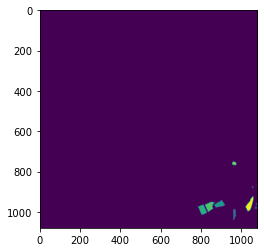

In [262]:
label = imageio.imread('../data/planet/france/sherrie10k/extent_labels/1250px_10field/original_thickness6/00051.png')
plt.imshow(label)
plt.show()

In [263]:
np.sum(label[:256*3,:256*3])

0

In [249]:
np.random.choice(zero_images, 5, replace=False)

array(['00059', '00066', '00128', '00062', '00104'], dtype='<U5')

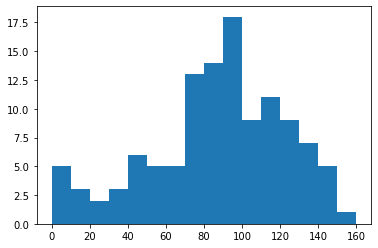

In [252]:
plt.hist(n_fields_actual.values(), bins=np.linspace(0, 160, 17))
plt.show()

In [228]:
n_fields

10253

In [218]:
len(parcels_dict['00105'])

279

In [191]:
np.sum((im[:256*3,:256*3] == 6) > 0)

8

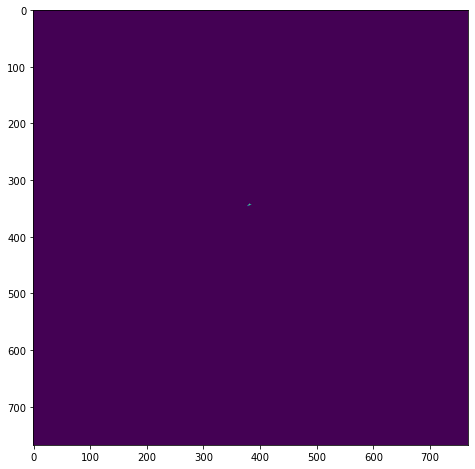

In [187]:
im = imageio.imread('../data/planet/france/sherrie10k/extent_labels/1250px_100field/original_thickness6/00018.png')
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.imshow(im[:256*3,:256*3] == 6)
plt.show()

In [136]:
np.sum(list(n_sampled_dict.values()))

2000

In [143]:
n_sampled_dict['00018']

40

In [145]:
np.unique(im[:256*3,:256*3])

Array([ 0,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 27, 28, 29, 30, 31, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52], dtype=uint8)

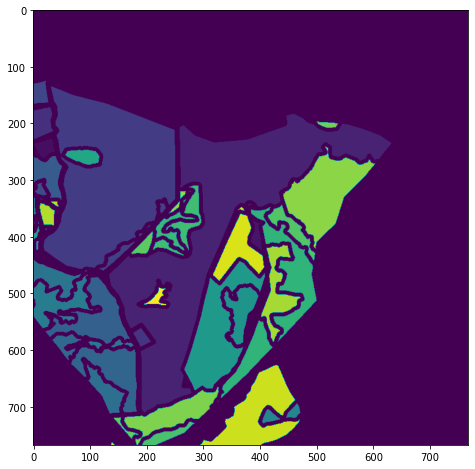

In [141]:
im = imageio.imread('../data/planet/france/sherrie10k/extent_labels/1250px_100field/original_thickness6/00018.png')
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.imshow(im[:256*3,:256*3])
plt.show()

In [97]:
np.sum(im == 11)

0